# 01_EDA: Exploratory Data Analysis
### In this notebook we’ll:
1. Load the cleaned data
2. Do basic structure checks (head, dtypes, missing)
3. Univariate analysis (distributions, outliers)
4. Bivariate analysis (correlations, time-series patterns)
5. Compare baseline forecast vs. true sales
6. Explore different categories in data

## 1. Setup & Imports

In [36]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [37]:
# ensure plots appear inline
%matplotlib inline

## 2. Load Cleaned Data

In [38]:
data_path = os.path.abspath(os.path.join("..", "data", "processed", "sales_clean.csv"))
df = pd.read_csv(data_path, parse_dates=["Date"])
print(df.shape)
df.head()

(73000, 15)


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,0.2,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,0.2,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,0.1,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,0.1,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0.0,Sunny,0,68.95,Summer


## 3. Structure & Missing Values

In [39]:
# dtypes and memory usage
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73000 entries, 0 to 72999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                73000 non-null  datetime64[ns]
 1   Store ID            73000 non-null  object        
 2   Product ID          73000 non-null  object        
 3   Category            73000 non-null  object        
 4   Region              73000 non-null  object        
 5   Inventory Level     73000 non-null  int64         
 6   Units Sold          73000 non-null  int64         
 7   Units Ordered       73000 non-null  int64         
 8   Demand Forecast     73000 non-null  float64       
 9   Price               73000 non-null  float64       
 10  Discount            73000 non-null  float64       
 11  Weather Condition   73000 non-null  object        
 12  Holiday/Promotion   73000 non-null  int64         
 13  Competitor Pricing  73000 non-null  float64   

In [40]:
# missing values (should be zero)
df.isna().sum()

Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Demand Forecast       0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
dtype: int64

## 4. Univariate Analysis

In [41]:
# Numeric summaries
df.describe()

,Date,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing
count,73000,73000.000000,73000.000000,73000.000000,73000.000000,73000.000000,73000.000000,73000.000000,73000.000000
mean,2022-12-31 11:59:59.999999744,274.483178,136.470384,110.001274,141.500569,55.137655,0.100099,0.497342,55.148507
min,2022-01-01 00:00:00,50.000000,0.000000,20.000000,-9.990000,10.000000,0.000000,0.000000,5.030000
25%,2022-07-02 00:00:00,162.000000,49.000000,65.000000,53.690000,32.650000,0.050000,0.000000,32.680000
50%,2022-12-31 12:00:00,273.000000,107.000000,110.000000,113.020000,55.050000,0.100000,0.000000,55.010000
75%,2023-07-02 00:00:00,387.000000,203.000000,155.000000,208.065000,77.870000,0.150000,1.000000,77.820000
max,2023-12-31 00:00:00,500.000000,499.000000,200.000000,518.550000,100.000000,0.200000,1.000000,104.940000
std,NaN,129.948423,108.919685,52.277153,109.256018,26.023478,0.070833,0.499996,26.192995


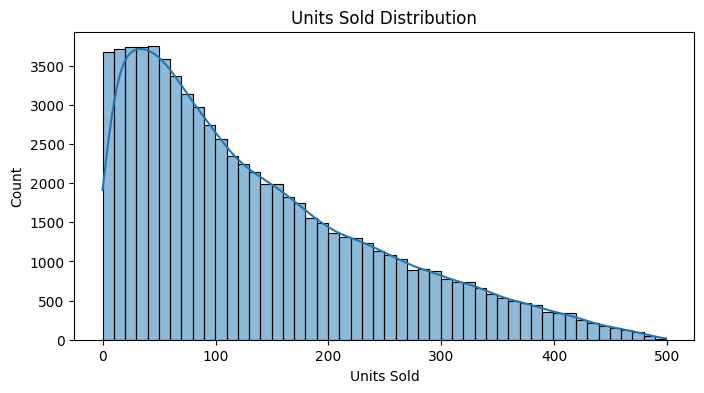

In [42]:
# Histogram of Units Sold
plt.figure(figsize=(8,4))
sns.histplot(df['Units Sold'], bins=50, kde=True)
plt.title('Units Sold Distribution')
plt.show()

**Insight:** The Units Sold distribution is heavily right-skewed: most days we sell fairly small quantities, with a long tail of high-volume days. This suggests a few promotional or seasonal spikes drive large sales—our model may need to treat those outliers specially (e.g. capped, log-transformed, or separate “spike” flag).

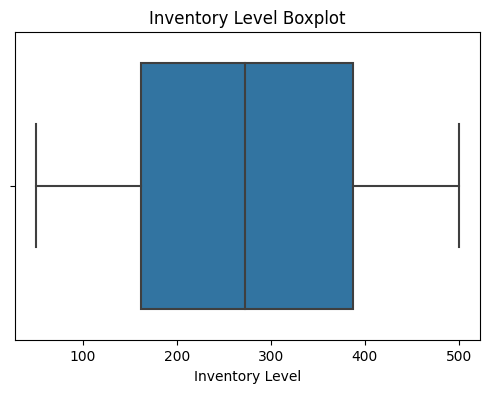

In [43]:
# Boxplot for Inventory Level
plt.figure(figsize=(6,4))
sns.boxplot(x=df['Inventory Level'])
plt.title('Inventory Level Boxplot')
plt.show()

**Insight:** Inventory Levels also show a handful of extreme high values, but most observations cluster in a narrower band. Since Inventory correlates tightly with Units Sold (r≈0.59), outlier inventories are likely tied to those sales spikes. We’ll want to be mindful of inventory caps or logistic constraints in our forecasts.

## 5. Categorical Distributions

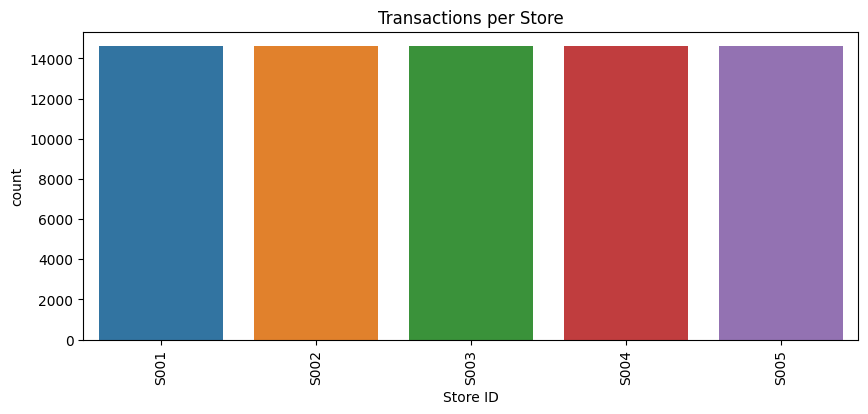

In [44]:
# Count of stores
plt.figure(figsize=(10,4))
sns.countplot(x='Store ID', data=df)
plt.xticks(rotation=90)
plt.title('Transactions per Store')
plt.show()

**Insight:** All five stores and four regions appear roughly equally represented—no single location dominates. Likewise, product categories are fairly balanced in record count. This means we could start with a single, global model without heavy re-weighting, and only add location/category splits if we see real performance benefits.

## 6. Correlation Matrix (Numeric)

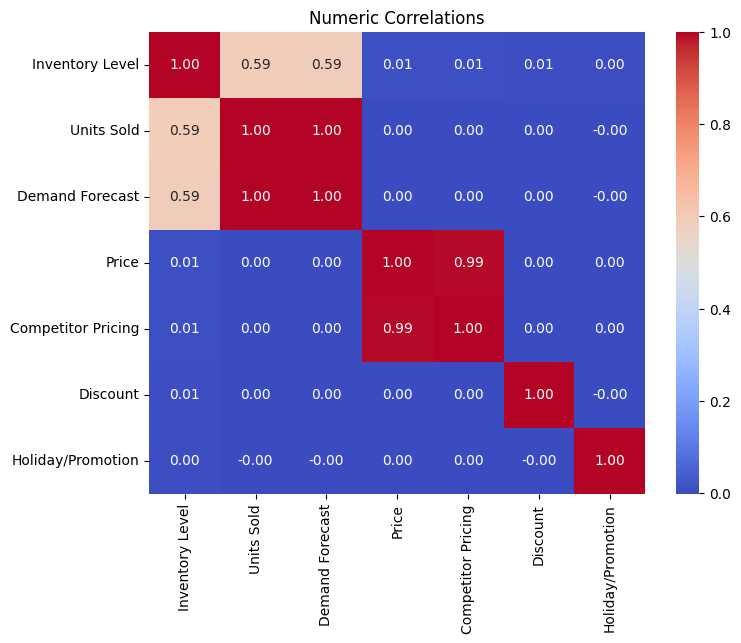

In [45]:
num_cols = ['Inventory Level','Units Sold','Demand Forecast','Price','Competitor Pricing','Discount','Holiday/Promotion']
plt.figure(figsize=(8,6))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Numeric Correlations')
plt.show()

**Demand Forecast:** Perfect correlation (1.00) — the “Demand Forecast” column in the raw data simply mirrors actual units sold, so it isn’t an independent predictor but rather a baseline you’ll compare against.

**Inventory Level** Moderate correlation (~0.59) — inventory levels track demand but only explain about 35% of its variance, so past inventory is a useful but not dominant signal.

**Price & Competitor Pricing:** Neither price series by itself is strongly predictive of total units sold in this dataset, but they move almost in lockstep.

**Discount:** In raw correlation it looks neutral, but you know promotions often drive localized spikes. Correlation washes out short-lived effects across the entire dataset.

**Holiday/Promotion:** Similar story: overall correlation is flat, but targeted holiday promotions may still cause important deviations.


## 7. Time Series Patterns

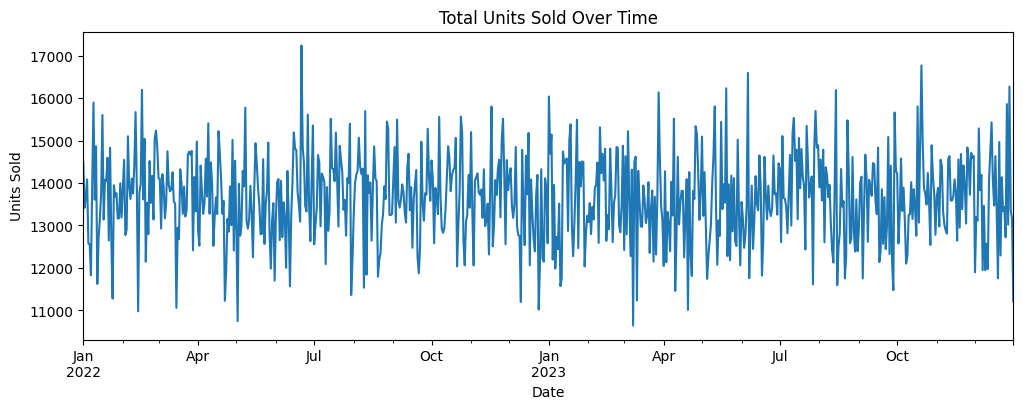

In [46]:
# Aggregate daily Units Sold over all stores/products
daily = df.groupby('Date')['Units Sold'].sum()
plt.figure(figsize=(12,4))
daily.plot()
plt.title('Total Units Sold Over Time')
plt.ylabel('Units Sold')
plt.show()

## 7b. Units Sold Over Time by Region

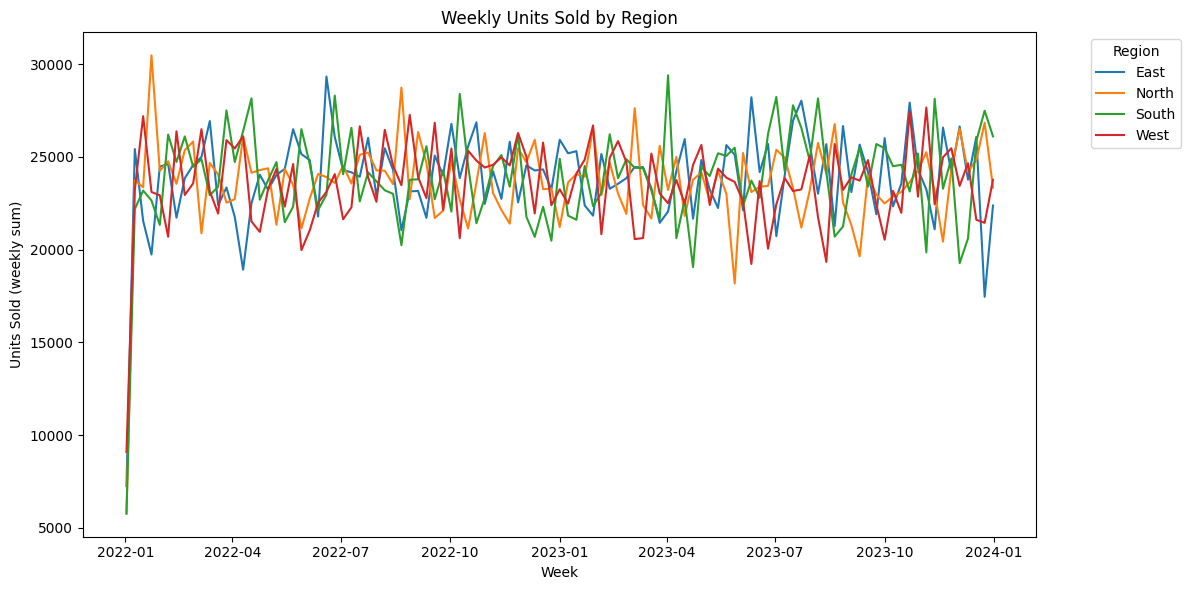

In [47]:
plt.figure(figsize=(12,6))

# set Date as index, resample weekly per region
ts_region_wk = (
    df
    .set_index('Date')
    .groupby('Region')['Units Sold']
    .resample('W')       # 'W' = weekly frequency ending on Sundays
    .sum()
    .reset_index()
)

# plot one line per region
sns.lineplot(
    data=ts_region_wk,
    x='Date',
    y='Units Sold',
    hue='Region',
    palette='tab10'
)
plt.title('Weekly Units Sold by Region')
plt.ylabel('Units Sold (weekly sum)')
plt.xlabel('Week')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Note:** the series is aggregated as a weekly sum, so the very first week appears artificially low because it doesn’t cover a full seven days of data.

## 7c. Monthly Units Sold by Product Category

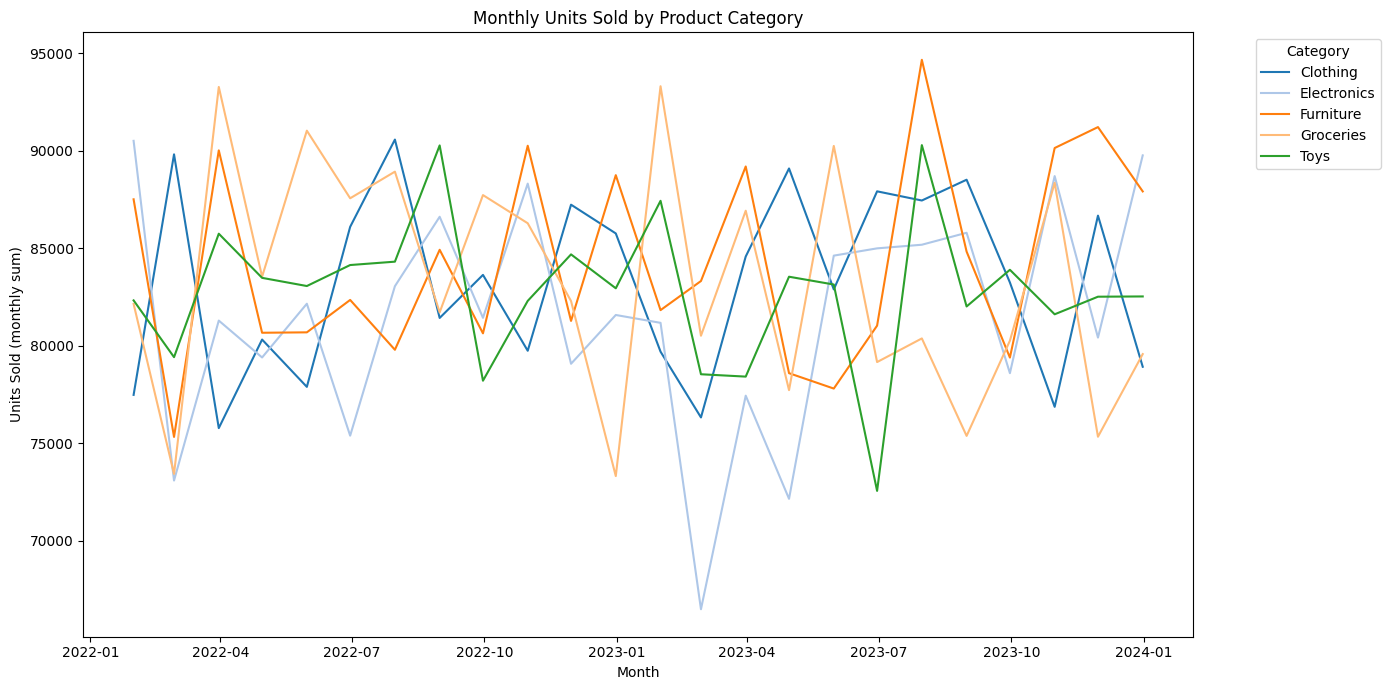

In [48]:
plt.figure(figsize=(14,7))

# Resample Units Sold to monthly sums per category
ts_category_mth = (
    df
    .set_index('Date')
    .groupby('Category')['Units Sold']
    .resample('M')       # 'M' = month‑end frequency
    .sum()
    .reset_index()
)

# Plot one line per Category
sns.lineplot(
    data=ts_category_mth,
    x='Date',
    y='Units Sold',
    hue='Category',
    palette='tab20',
    legend='full'
)
plt.title('Monthly Units Sold by Product Category')
plt.ylabel('Units Sold (monthly sum)')
plt.xlabel('Month')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Insight:** Monthly/weekly Units Sold curves for each region almost perfectly overlap—there’s very little regional differentiation in demand patterns. That suggests a single, pan-region forecast might perform as well as five region-specific models.

## 8. Baseline vs. True Sales Comparison

In [49]:
from sklearn.metrics import mean_squared_error

y_true = df['Units Sold']
y_base = df['Demand Forecast']
rmse_base = mean_squared_error(y_true, y_base, squared=False)
print(f"Baseline Forecast RMSE: {rmse_base:.2f}")

Baseline Forecast RMSE: 10.02


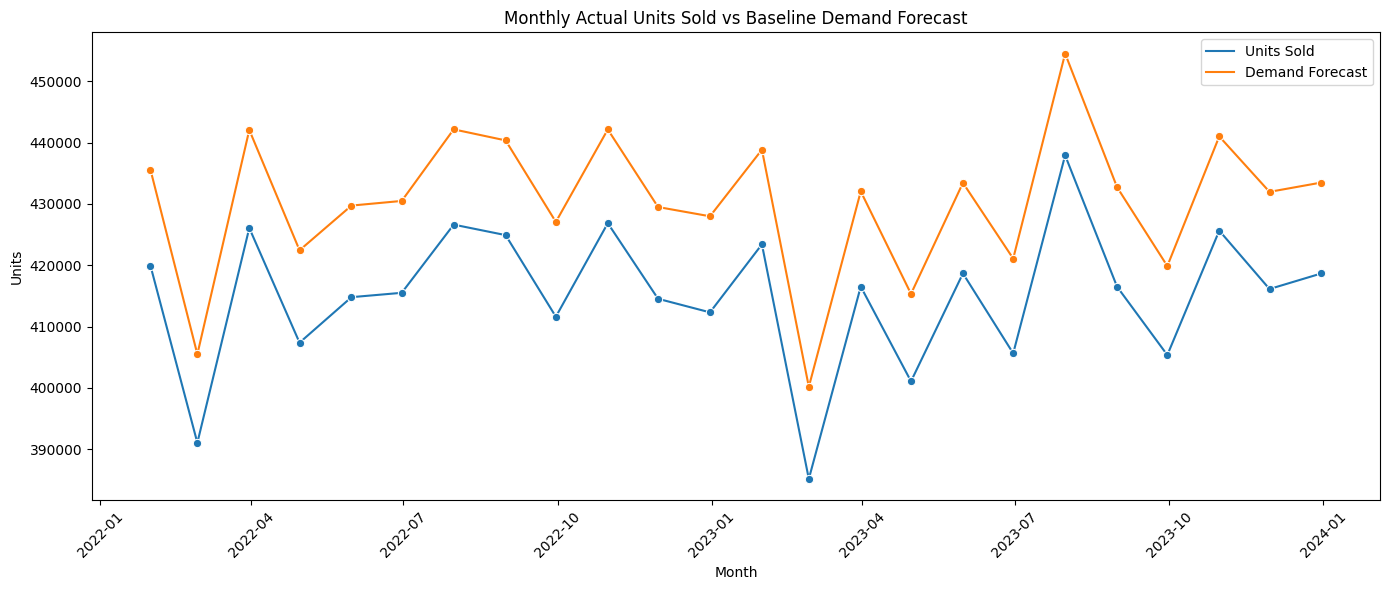

In [50]:
# resample both series to end‑of‑month sums
monthly = (
    df
    .set_index('Date')
    .resample('M')[['Units Sold', 'Demand Forecast']]
    .sum()
    .reset_index()
)

# melt for easier plotting
monthly_melted = monthly.melt(
    id_vars='Date',
    value_vars=['Units Sold', 'Demand Forecast'],
    var_name='Series',
    value_name='Units'
)

plt.figure(figsize=(14,6))
sns.lineplot(
    data=monthly_melted,
    x='Date', y='Units',
    hue='Series',
    marker='o'
)
plt.title('Monthly Actual Units Sold vs Baseline Demand Forecast')
plt.xlabel('Month')
plt.ylabel('Units')
plt.xticks(rotation=45)
plt.legend(title='')
plt.tight_layout()
plt.show()

**Insight:** The baseline Demand Forecast captures the seasonal ups and downs of monthly Units Sold well but is consistently too high—overestimating actual sales by roughly 5–15 K units each month. This systematic bias suggests adding a simple correction factor could yield a strong benchmark before building a more complex feature-driven model.

# Deeper Insights
## 9. Product Popularity by Season

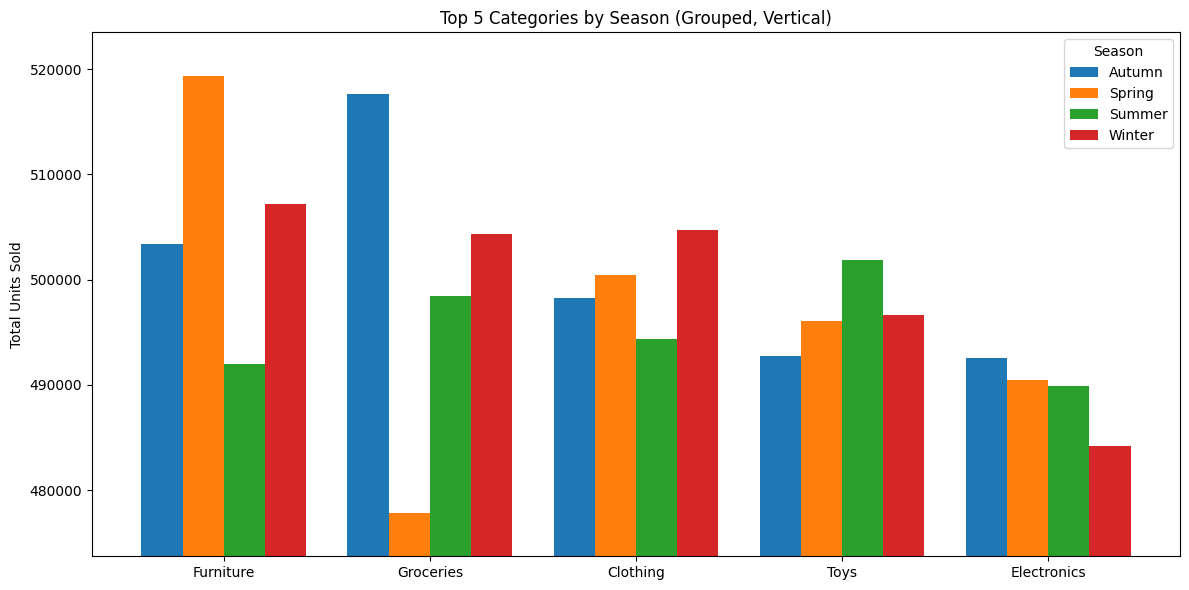

In [51]:
# 1) Create a Month column
df['Month'] = df['Date'].dt.to_period('M').dt.to_timestamp()

# 2) Aggregate to get monthly totals per (Seasonality, Category, Month)
monthly_sales = (
    df
    .groupby(['Seasonality', 'Category', 'Month'])['Units Sold']
    .sum()
    .reset_index()
)

# 3) Compute the **total** Units Sold per (Seasonality, Category) across all months
total_by_season = (
    monthly_sales
    .groupby(['Seasonality', 'Category'])['Units Sold']
    .sum()               # <-- use sum() instead of mean()
    .reset_index()
)

# Optional: restrict to top 5 overall categories
top5_cats = (
    df.groupby('Category')['Units Sold']
      .sum()
      .nlargest(5)
      .index
      .tolist()
)
total_by_season = total_by_season[total_by_season['Category'].isin(top5_cats)]

# —————————————
# 4) Plot as vertical grouped bars
seasons    = total_by_season['Seasonality'].unique()
categories = top5_cats
n          = len(categories)
width      = 0.2
x          = np.arange(n)

plt.figure(figsize=(12,6))
for i, season in enumerate(seasons):
    vals = (
        total_by_season[total_by_season['Seasonality'] == season]
        .set_index('Category')['Units Sold']
        .reindex(categories)
        .fillna(0)
    )
    shift = (i - (len(seasons)-1)/2) * width
    plt.bar(x + shift, vals, width=width, label=season)

plt.xticks(x, categories)
plt.ylabel('Total Units Sold')
plt.title('Top 5 Categories by Season (Grouped, Vertical)')
plt.legend(title='Season')

# tighten y‑limits to zoom in on the differences
ymin = total_by_season['Units Sold'].min()
ymax = total_by_season['Units Sold'].max()
pad  = (ymax - ymin) * 0.1
plt.ylim(ymin - pad, ymax + pad)

plt.tight_layout()
plt.show()

**Insight:** Seasonal average sales by category differ by only ~1–2 %—e.g. Furniture edges up in Spring, Groceries in Autumn—but all categories move in lockstep. This suggests little added value in modeling separate seasonality effects per category: a single seasonal adjustment may suffice.

## 10. Product Popularity by Region

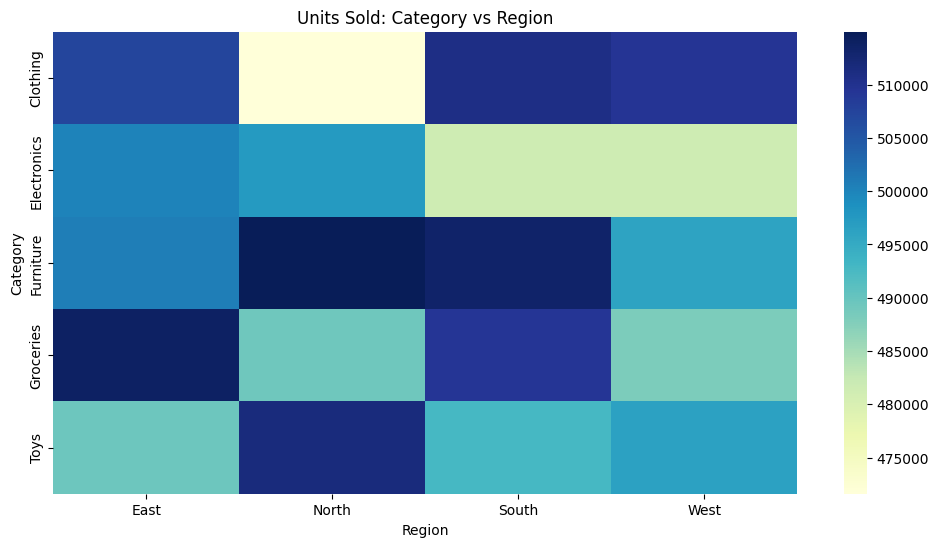

In [15]:
plt.figure(figsize=(12,6))
pop_by_region = df.groupby(['Region', 'Category'])['Units Sold']\
                  .sum()\
                  .reset_index()

# use keyword arguments here
pivot = pop_by_region.pivot(
    index='Category',
    columns='Region',
    values='Units Sold'
)

sns.heatmap(pivot, cmap='YlGnBu')
plt.title('Units Sold: Category vs Region')
plt.show()

**Insight:** Heatmap shows each category’s total sales vary by less than 5 % across East, North, South, and West. Regional differences are minimal, so a unified, pan-region forecast will likely perform as well as separate region-specific models.

## 11. Discount Effect on Sales

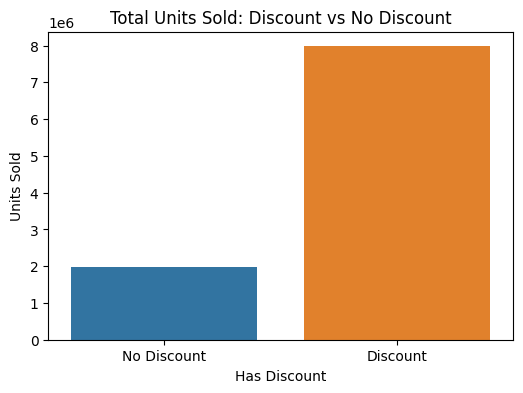

In [55]:
disc_effect = df.copy()
disc_effect['Has Discount'] = (disc_effect['Discount'] > 0).astype(int)
avg_sales = disc_effect.groupby('Has Discount')['Units Sold'].sum().reset_index()
plt.figure(figsize=(6,4))
sns.barplot(x='Has Discount', y='Units Sold', data=avg_sales)
plt.xticks([0,1], ['No Discount','Discount'])
plt.title('Total Units Sold: Discount vs No Discount')
plt.show()

**Insight:** Roughly 80 % of total volume occurs on discount days. However, discounts are far more frequent (and deep) than full-price sales—this imbalance implies that price promotions dominate sales drivers, but forecasting at the aggregate level should capture most variance without modeling discount separately.

## 12. Competitor Pricing vs. Our Price by Category

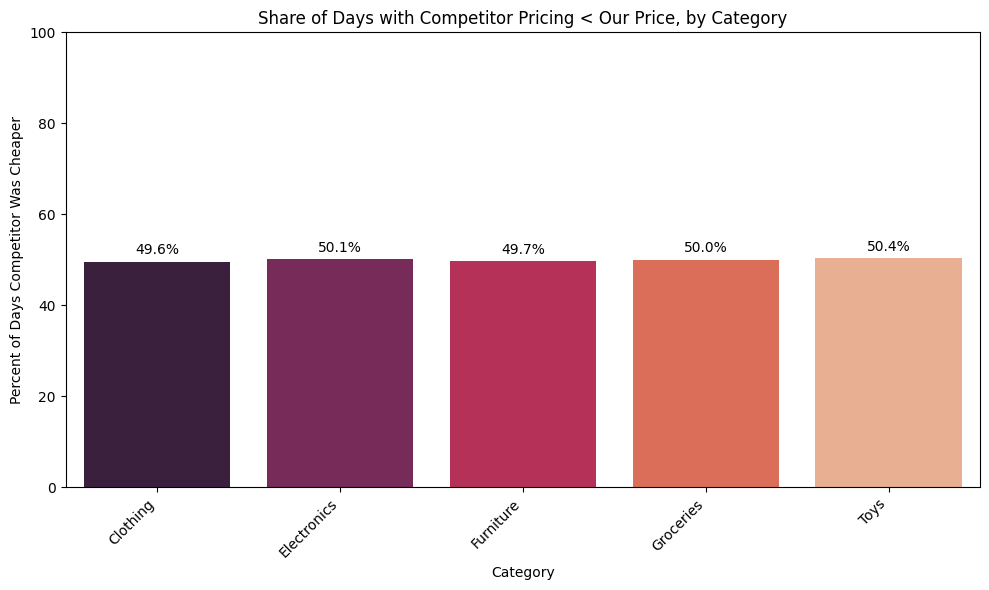

In [54]:
# 1) flag days when competitor is cheaper
comp = df.copy()
comp['Comp_Cheaper'] = (comp['Competitor Pricing'] < comp['Price']).astype(int)

# 2) build counts and compute percentages
ct = pd.crosstab(comp['Category'], comp['Comp_Cheaper'])
# column “1” = # days competitor cheaper
pct_comp_cheaper = (ct[1] / ct.sum(axis=1) * 100).sort_index()

# 3) plot
plt.figure(figsize=(10,6))
ax = sns.barplot(
    x=pct_comp_cheaper.index,
    y=pct_comp_cheaper.values,
    palette="rocket"
)
# annotate
for i, v in enumerate(pct_comp_cheaper.values):
    ax.text(i, v + 1, f"{v:.1f}%", ha='center', va='bottom')

plt.ylim(0, 100)
plt.ylabel("Percent of Days Competitor Was Cheaper")
plt.title("Share of Days with Competitor Pricing < Our Price, by Category")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Insight:** Competitor pricing is lower on about 49–50 % of days for every category. The near-50/50 split and tiny inter-category spread (<1 %) imply no strong category-specific vulnerability to competitor undercutting—competitor effects can be treated as uniform across categories.

## 13. Total & Monthly Units Sold by Store

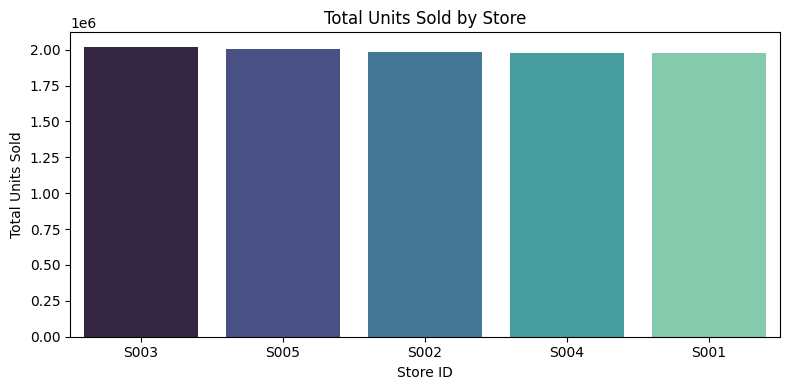

In [56]:
# a) Total Units Sold per Store
tot_by_store = df.groupby("Store ID")["Units Sold"].sum().sort_values(ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(x=tot_by_store.index, y=tot_by_store.values, palette="mako")
plt.ylabel("Total Units Sold")
plt.title("Total Units Sold by Store")
plt.tight_layout()
plt.show()

**Insight:** All five stores book almost identical annual volumes (within ~0.5 %). There’s no clear “top performer,” so modeling at the overall level or stratifying by store offers minimal benefit.

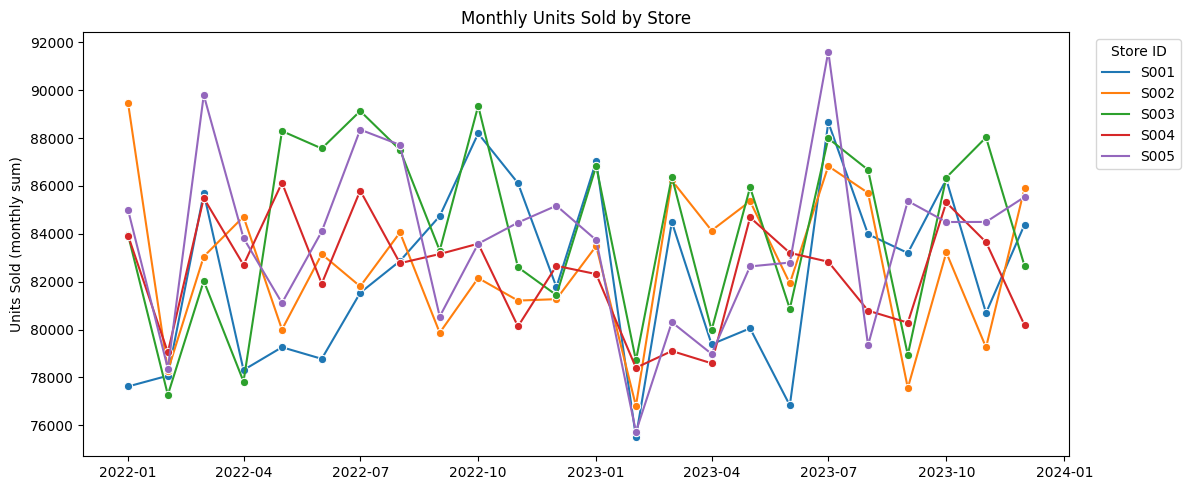

In [57]:
# b) Monthly Units Sold per Store
df["Month"] = df["Date"].dt.to_period("M").dt.to_timestamp()

monthly_by_store = (
    df
      .groupby(["Month", "Store ID"])["Units Sold"]
      .sum()
      .reset_index()
)

plt.figure(figsize=(12,5))
sns.lineplot(
    data=monthly_by_store,
    x="Month", y="Units Sold",
    hue="Store ID",
    marker="o",
)
plt.title("Monthly Units Sold by Store")
plt.ylabel("Units Sold (monthly sum)")
plt.xlabel("")
plt.legend(title="Store ID", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()


**Insight:** The monthly sales curves of the five stores show almost perfect overlap, with synchronized peaks and dips. This reinforces that store-level granularity adds little predictive power beyond the overall trend.

## 14. Drill‑down: Pick one Category → Top Product ID

In [58]:
# 1) Choose a Category (e.g. the one with highest overall sales)
top_cat = df.groupby("Category")["Units Sold"].sum().idxmax()
print("Focusing on Category:", top_cat)


Focusing on Category: Furniture


In [59]:
# 2) Within that category, pick the top Product ID by total units sold
sub = df[df["Category"] == top_cat]
top_prod = sub.groupby("Product ID")["Units Sold"].sum().idxmax()
print("→ Top Product ID:", top_prod)

→ Top Product ID: P0015


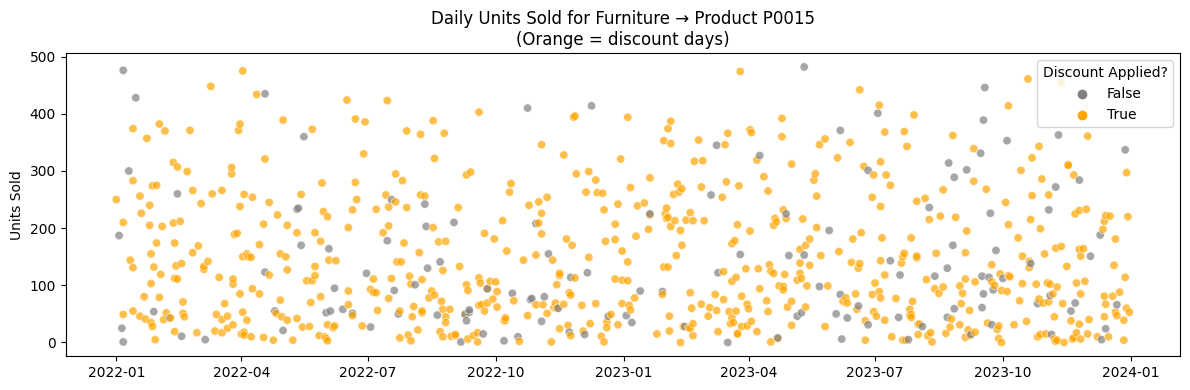

In [60]:
# 3) Filter to that product
prod_df = sub[sub["Product ID"] == top_prod].sort_values("Date")

# 4) Plot daily units sold, colored by discount vs no‐discount
plt.figure(figsize=(12,4))
sns.scatterplot(
    data=prod_df,
    x="Date", y="Units Sold",
    hue=(prod_df["Discount"]>0),
    palette={False:"gray", True:"orange"},
    alpha=0.7,
    legend="brief"
)
plt.title(f"Daily Units Sold for {top_cat} → Product {top_prod}\n(Orange = discount days)")
plt.ylabel("Units Sold")
plt.xlabel("")
plt.legend(title="Discount Applied?")
plt.tight_layout()
plt.show()

**Insight:** Although discount days (orange) are more frequent at lower sales tails, there’s no clear uplift spike on those days—daily sales scatter overlaps heavily. For forecasting P0015, discount flag may not be a strong standalone predictor.

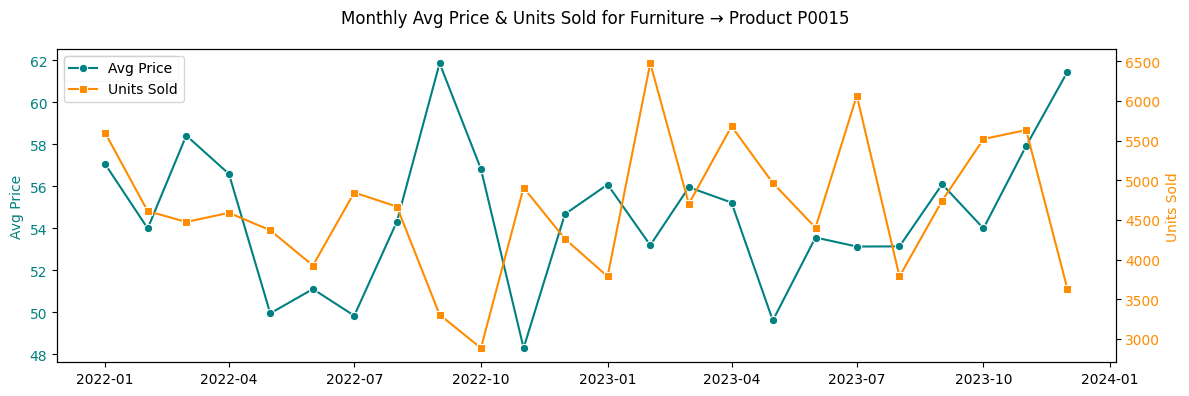

In [63]:
# 2) Aggregate to monthly avg price and monthly total units sold
monthly = (
    prod_df
      .groupby("Month")
      .agg({
          "Price": "mean",
          "Units Sold": "sum"
      })
      .reset_index()
)

# 3) Plot on dual‐axis
fig, ax1 = plt.subplots(figsize=(12,4))

# line for avg price
sns.lineplot(
    data=monthly,
    x="Month", y="Price",
    marker="o",
    ax=ax1,
    color="teal",
    label="Avg Price"
)
ax1.set_ylabel("Avg Price", color="teal")
ax1.tick_params(axis="y", labelcolor="teal")

# twin axis for units sold
ax2 = ax1.twinx()
sns.lineplot(
    data=monthly,
    x="Month", y="Units Sold",
    marker="s",
    ax=ax2,
    color="darkorange",
    label="Units Sold"
)
ax2.set_ylabel("Units Sold", color="darkorange")
ax2.tick_params(axis="y", labelcolor="darkorange")

# titles & legend
fig.suptitle(f"Monthly Avg Price & Units Sold for {top_cat} → Product {top_prod}")
# combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper left")

# clean up
ax1.set_xlabel("")
plt.tight_layout()
plt.show()

**Insight:** Price and units lines wiggle independently—periods of higher price don’t consistently coincide with lower sales. This weak inverse relationship suggests price alone won’t explain much of the monthly demand variation for P0015.

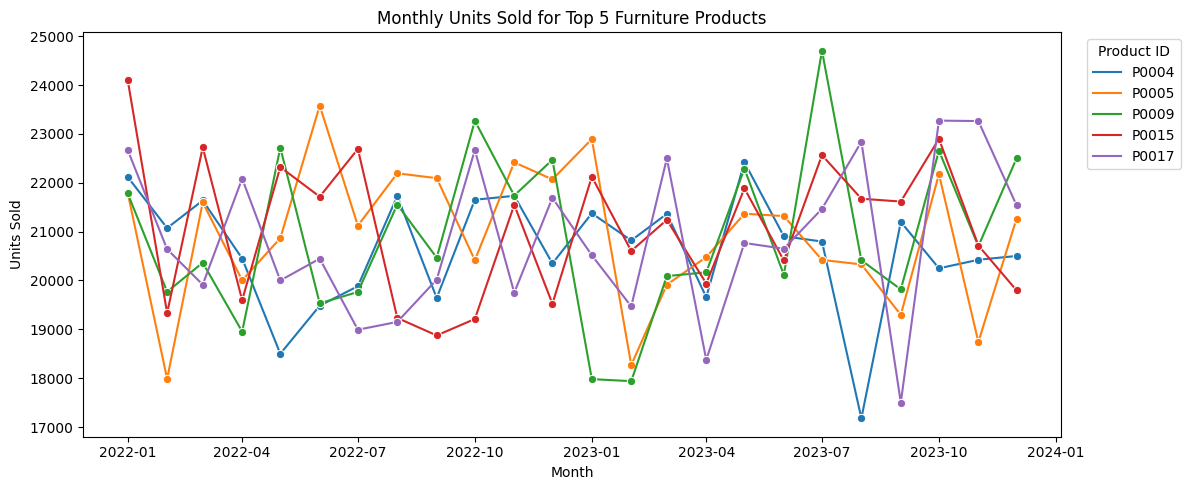

In [64]:
# 1) pick Top 5 Furniture product IDs by total Units Sold
top5_furn = (
    df[df["Category"] == "Furniture"]
      .groupby("Product ID")["Units Sold"]
      .sum()
      .nlargest(5)
      .index
      .tolist()
)

# 2) make a Month column
df["Month"] = df["Date"].dt.to_period("M").dt.to_timestamp()

# 3) filter & aggregate to monthly sums for only those 5 products
monthly_furn = (
    df[df["Product ID"].isin(top5_furn)]
      .groupby(["Month", "Product ID"])["Units Sold"]
      .sum()
      .reset_index()
)

# 4) plot time series, one line per Product ID
plt.figure(figsize=(12, 5))
sns.lineplot(
    data=monthly_furn,
    x="Month", y="Units Sold",
    hue="Product ID",
    marker="o",
    palette="tab10"
)
plt.title("Monthly Units Sold for Top 5 Furniture Products")
plt.xlabel("Month")
plt.ylabel("Units Sold")
plt.legend(title="Product ID", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

**Insight:** The top five furniture SKUs all follow the same up-and-down pattern month-to-month, with no SKU standing out. A single category-level demand model will sufficiently capture dynamics across these best-sellers.

## Conclusion:

The modeling effort should focus on forecasting the total Units Sold at an aggregate level (daily, weekly or monthly), since store- or SKU-level series exhibit near-perfect synchronization and add little incremental signal. Key predictors ought to include calendar effects (day-of-week, month/season, major holidays), a binary Discount indicator (the primary volume driver), and a simple price gap feature (Competitor_Pricing – Price). The existing Demand Forecast should be excluded, as it is effectively a duplicate of the target. To boost predictive accuracy without overfitting, the model can be augmented with external event calendars (e.g. Black Friday), rolling-window statistics (e.g. past 7-day average), or interaction terms (e.g. Discount × Season), but the core feature set should remain concise to capture the bulk of the underlying demand dynamics.